In [1]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig

from torch._tensor import Tensor
import importlib


from botorch.models import SingleTaskGP
import math
import importlib

from src import GPVisualiser, ax_helper
from botorch.models import SingleTaskGP
from src.model_generation import get_full_strategy
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy
from botorch.models import SingleTaskGP
from typing import Literal
import pandas as pd
import seaborn as sns


from src.ax_helper import get_guess_coords


importlib.reload(GPVisualiser)


<module 'src.GPVisualiser' from 'c:\\GitHub\\BO-Coli\\src\\GPVisualiser.py'>

<Axes: >

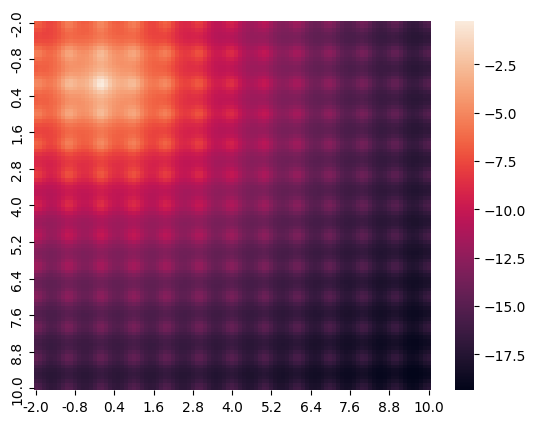

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    return -ackley_grid


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
sns.heatmap(
    pd.DataFrame(ackley_vals, index=np.round(grid, 2), columns=np.round(grid, 2)),
    xticklabels=10,
    yticklabels=10
)

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-21 15:25:46] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-21 15:25:46] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 15:25:46] ax.api.client: Generated new trial 1 with parameters {'x0': 99.123031, 'x1': 67.414857} using GenerationNode Sobol.
[INFO 09-21 15:25:46] ax.api.client: Generated new trial 2 with parameters {'x0': 5.150053, 'x1': 2.701375} using GenerationNode Sobol.
[INFO 09-21 15:25:46] ax.api.client: Generated new tri

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  99.123031  67.414857
2         2_0   5.150053   2.701375
3         3_0   1.669143  26.976970
4         4_0  27.827767   6.731849
5         5_0  13.472186  12.233023
6         6_0   2.551061   4.707761
7         7_0   7.973583  47.009478
8         8_0  48.667276   1.221615
9         9_0  31.767938  18.663550
10       10_0   6.138480   9.914263
11       11_0   1.901460  99.227033
12       12_0  11.373176   1.867817
13       13_0  23.427034  33.713509
14       14_0   1.236490   1.735513
15       15_0   3.971604  17.369638
16       16_0  65.180081   3.374398
17       17_0  58.320913  13.698993
18       18_0   3.560655   3.947844
19       19_0   1.036526  39.422601
20       20_0  19.588830   1.368061
21       21_0  12.653563  75.496491
22       22_0   2.111368   2.265399
23       23_0   7.355553  22.622396
24       24_0  38.162973   7.538575
25       25_0  54.022701  50.269511
26       26_0   8.873428   1

<Axes: xlabel='x0', ylabel='x1'>

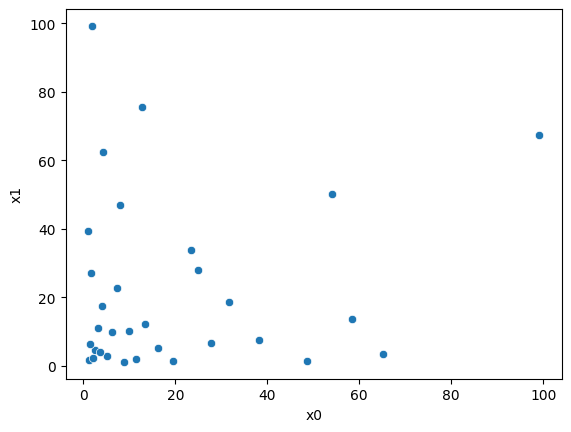

In [3]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-21 15:25:46] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 1 with parameters {'x1': 75.916809, 'x2': 18.598333} using GenerationNode Sobol.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 2 with parameters {'x1': 1.770739, 'x2': 62.362071} using GenerationNode Sobol.
[INFO 09-21 15:25:47] ax.api.client: Generated new tr

<Axes: xlabel='x1', ylabel='x2'>

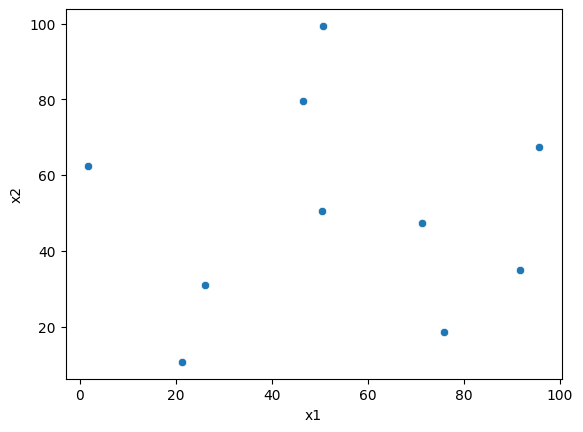

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-21 15:25:47] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 1 with parameters {'x1': 9.449331, 'x2': 7.923169} using GenerationNode Sobol.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 2 with parameters {'x1': 3.821331, 'x2': 2.004337} using GenerationNode Sobol.
[INFO 09-21 15:25:47] ax.api.client: Generated new trial 3

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

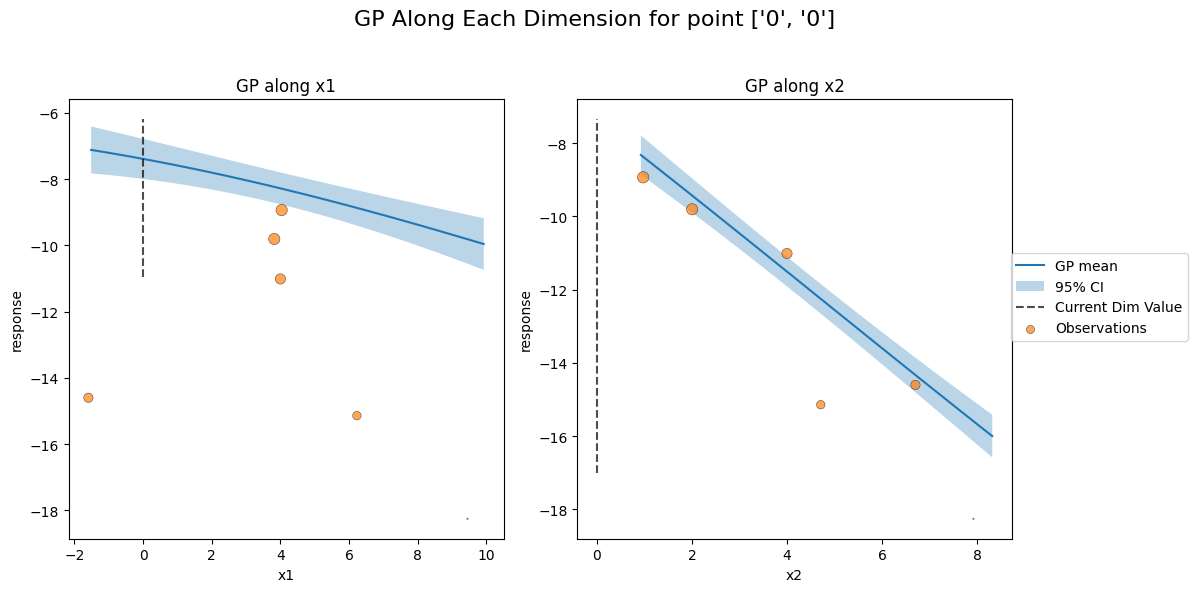

In [5]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [6]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-11.013421
1,1_0,9.449331,7.923169,-18.253185
2,2_0,3.821331,2.004337,-9.806713
3,3_0,-1.592105,6.703545,-14.600068
4,4_0,4.035707,0.973685,-8.933477
5,5_0,6.227559,4.710568,-15.140306


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

[INFO 09-21 15:25:48] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 15:25:48] ax.api.client: Generated new trial 1 with parameters {'x1': 3.939766, 'x2': 0.30397} using GenerationNode Sobol.
[INFO 09-21 15:25:48] ax.api.client: Generated new trial 2 with parameters {'x1': 6.630782, 'x2': 5.964056} using GenerationNode Sobol.
[INFO 09-21 15:25:48] ax.api.client: Generated new trial 3 with parameters {'x1': 8.155042, 'x2': 1.854855} using GenerationNode Sobol.
[INFO 09-21 15:25:48] ax.api.client: Generated new trial 4 with parameters {'x1': -0.59145, 'x2': 7.514943} using GenerationNode Sobol.
[INFO 09-21 15:25:48] ax.api.client: Generated new trial 5 with parameters {'x1': 0.183012, 'x2': 3.477267} using GenerationNode Sobol.
[INFO 09-21 15:25:48] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-21 15:25:48] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-21 15:25:48] ax.api.client: Trial 2 marked COM

[INFO 09-21 15:25:54] ax.api.client: Generated new trial 6 with parameters {'x1': 1.783378, 'x2': 1.861333} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:25:54] ax.api.client: Generated new trial 7 with parameters {'x1': 0.25408, 'x2': 0.388913} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:25:54] ax.api.client: Generated new trial 8 with parameters {'x1': 2.161909, 'x2': 2.395584} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:25:54] ax.api.client: Generated new trial 9 with parameters {'x1': -2.0, 'x2': 0.604812} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:25:54] ax.api.client: Generated new trial 10 with parameters {'x1': 0.531493, 'x2': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:25:54] ax.api.client: Generated new trial 11 with parameters {'x1': 5.183428, 'x2': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-

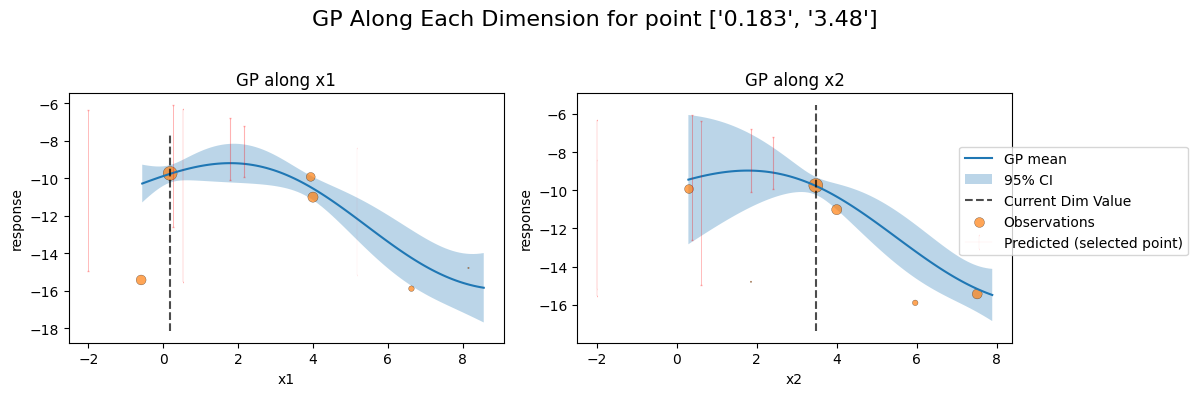

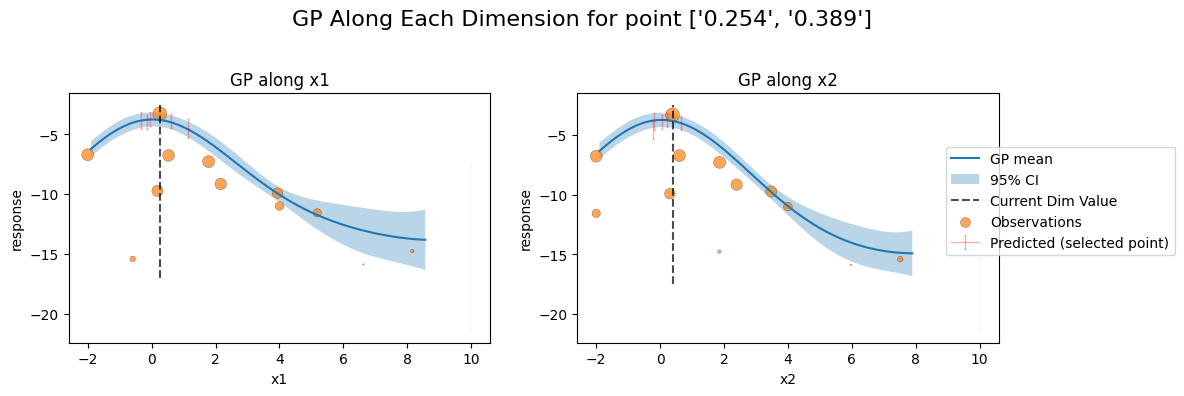

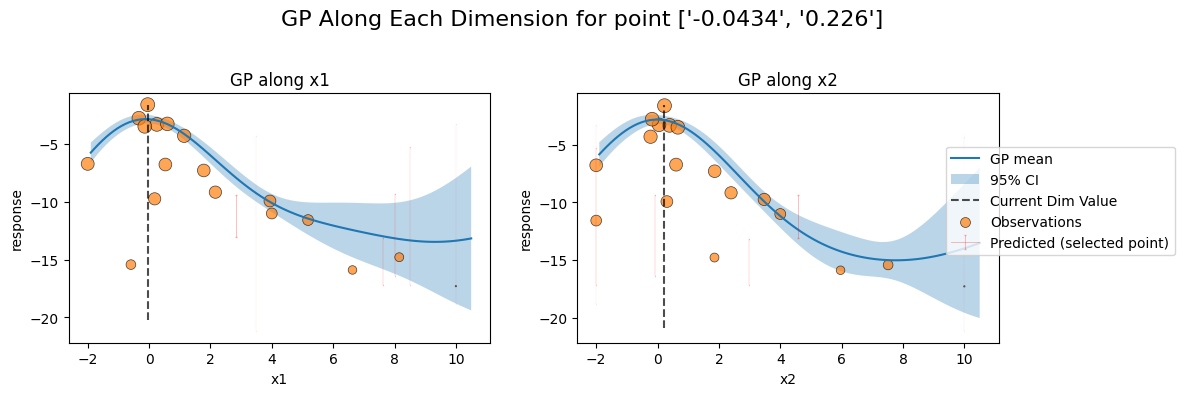

In [8]:
import matplotlib.pyplot as plt
for _ in range(3):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()

In [9]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-11.013421
1,1_0,9.449331,7.923169,-18.253185
2,2_0,3.821331,2.004337,-9.806713
3,3_0,-1.592105,6.703545,-14.600068
4,4_0,4.035707,0.973685,-8.933477
5,5_0,6.227559,4.710568,-15.140306


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [10]:



range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

test_function = lambda x1: -((x1-2)**2) + 10
noise_fn = lambda x: x + np.random.normal(0, 10)

[INFO 09-21 15:27:22] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 15:27:22] ax.api.client: Generated new trial 1 with parameters {'x1': 7.495579} using GenerationNode Sobol.


[INFO 09-21 15:27:22] ax.api.client: Generated new trial 2 with parameters {'x1': 1.056797} using GenerationNode Sobol.
[INFO 09-21 15:27:22] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-21 15:27:22] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-21 15:27:23] ax.api.client: Generated new trial 9 with parameters {'x1': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15:27:23] ax.api.client: Generated new trial 10 with parameters {'x1': 2.444461} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-21 15

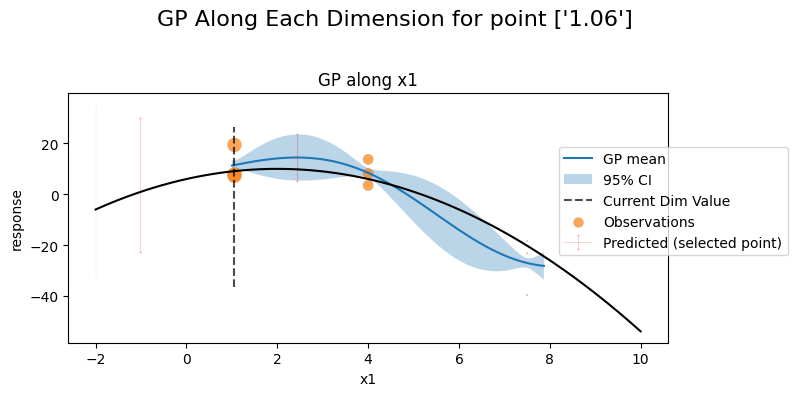

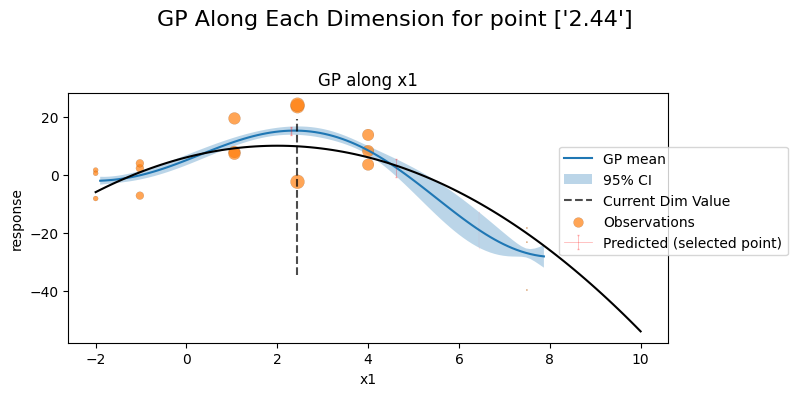

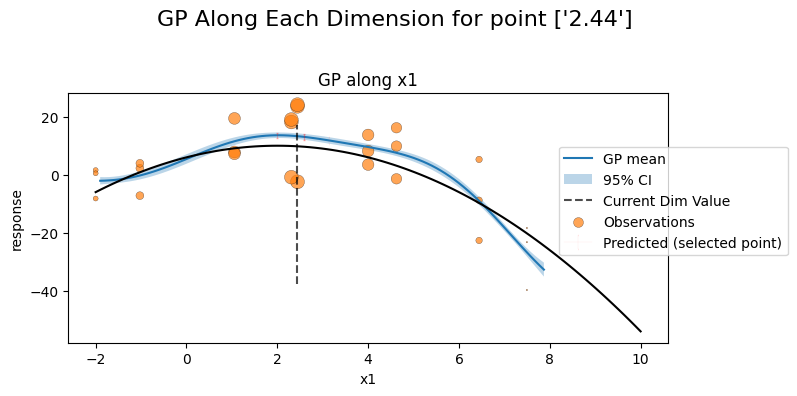

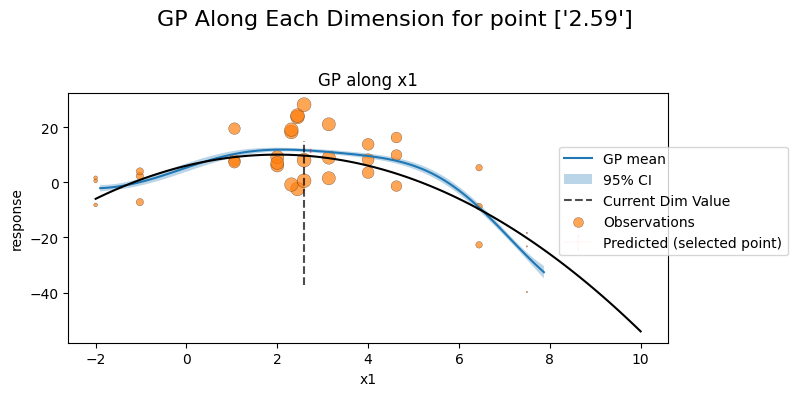

In [12]:
importlib.reload(ax_helper)


client = Client()

client.configure_experiment(parameters=range_parameters)
client.configure_optimization(objective=metric_name)

generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.set_generation_strategy(
    generation_strategy=generation_strategy,
)



handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=3, range_params=range_parameters)
handler.get_next_batch(3)



for _ in range(4):
    handler.comp_noise_and_repeats(noise_fn=noise_fn, repeats=3)
    handler.get_next_batch()
    handler.plot_GP(SingleTaskGP, figsize=(8, 4))
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')



* This simple Kernel is incapable of encompassing noise.